# End-to-end Example

This notebook runs through a long-ish example of using the modules to analyze some survey data.

## Imports and setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import json
import random
from typing import Any
from pprint import pprint
from IPython.display import Markdown, display, HTML
from pathlib import Path
from feedback_analyzer.summarization import summarize_comments
from feedback_analyzer.theme_derivation import find_themes
from feedback_analyzer.theme_derivation import find_themes
from feedback_analyzer.sentiment_analysis import (
    classify_sentiment, 
    SentimentAnalysisResult,
    display_top_comments,
    visualize_sentiment_results
)
from feedback_analyzer.excerpt_extraction import extract_excerpts
from feedback_analyzer.multilabel_classification import multilabel_classify, default_tags_list

%matplotlib inline

In [3]:
# this makes it more robust to run async tasks inside an already async environment (jupyter notebooks)
import nest_asyncio
nest_asyncio.apply()

Make sure to either set `ANTHROPIC_API_KEY` as an environment variable or put it in a .env file and use the following cell to load the env var. The format in the .env file is:
```
ANTHROPIC_API_KEY=yourKeyGoesHere
```

In [4]:
%load_ext autoreload
%autoreload 2

This is a convenience function to make seeing Pandas dataframe values easier, especially when there are long strings like the student comments we will be using.

In [5]:
def full_show(df):
    with pd.option_context('display.max_columns', None, 'display.max_rows', None, 'display.max_colwidth', None):
        display(df)

This is a convenience function for pretty-printing long student comments.

In [6]:
def print_wrap(text: str, width: int = 72) -> str:
    print(textwrap.fill(text, width=width))

## Load the example data

In [7]:
data_path = Path('../data/example_data')

Let's load up some fake data. 

All of these comments are synthetic to avoid sharing any sensitive or PII information, but they should work great for illustration purposes. There are 100 rows, with just a few null/nan values here and there for realism. In most surveys I've seen, there are quite a number of null/None/blank etc values, so the functions here are written to handle those.

In [8]:
example_survey = pd.read_csv(data_path / 'example_survey_data_synthetic.csv')
full_show(example_survey.head())

,best_parts,enhanced_learning,improve_course
0,I valued the practical clinical aspects related to immune-related disorders and their management.,The illustrative visuals and straightforward explanatory clips.,Consider reducing the duration of certain videos. A few appeared to be slightly prolonged.
1,The flexibility to learn at a self-determined speed,The opportunity to review the lecture content,"The pace of some lectures could be slowed down. At times, it's challenging to follow the lecturer's speech or decipher their handwriting."
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,the self-assessment activities.,Nothing specific comes to mind.
3,Professional growth within the medical sector,"The practical integration workshops were highly beneficial, they significantly contributed to a deeper comprehension of the theories and their implementation in a healthcare environment.",Incorporating a few advanced projects as optional tasks could benefit learners who wish to delve deeper into the subject matter. These projects wouldn't need to influence exam scores.
4,The highlights of the class included the practical demonstration clips that made the complex biological principles more understandable by connecting them to daily well-being and actions. This connection was incredibly beneficial as I navigated the course content.,"The aspect of the course that most facilitated my learning was the regular assessments provided at each segment, which helped confirm my grasp of the material presented. These checkpoints effectively guided me in the correct learning direction. It's evident that considerable effort was invested in designing these educational modules to enable students to gain a deep comprehension rather than just a superficial understanding of the subject matter.","Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved. Additionally, consider introducing an additional educator to the mix. The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."


## Plan

We're going to analyze to some example survey questions. The main overall goals are to show how one might explore the following questions:

1. What did students say about the course? (themes, summarization)
2. How did they feel about the course? (sentiment analysis)
3. What did they say about some aspect of interest? (extraction)
4. How did they feel about that aspect (focused sentiment analysis)
5. How many comments were there about different aspects? (multilabel classification)

If you're interested in this sort of thing, have a look at the paper called [A Large Language Model Approach to Educational Survey Feedback Analysis](https://arxiv.org/pdf/2309.17447.pdf). 

For the survey we'll be analyzing, there were three survey questions of interest. We'll define the questions themselves in variables for use later. We'll use these as metadata when passing along comments to the LLM routines. This is potentially important context for an LLM...after all, the survey comment "The flexibility to learn at a self-determined speed" may have different significance if the question was "What were the best parts of the course?" versus "What could be improved about the course?".

In [75]:
best_parts_question = "What were the best parts of the course?"
enhanced_learning_question = "What parts of the course enhanced your learning the most?"
improve_course_question = "What could be improved about the course?"

## 1. What did students say about the course?

When confronted with survey results, this is the high-level (vibes) step of getting a feel for what the major pieces of feedback were. Each question has its own context, so we'll analyze the results from each question separately. We'll look at a bottom-up approach versus a top-down approach.

### Theme derivation (bottom-up approach)

Here we'll come in without preconceived notions or categories and let the model derive the themes (from the bottom up, based on the comments). Let's find the themes (common feedback expressed by multiple students), first from the "What were the best parts of the course?" survey question and then from the "What could be improved about the course?" question. This bottom-up approach has a fancy, academic name: inductive thematic analysis. But it's easier to call it "bottom-up".

In [12]:
best_parts_comments = example_survey['best_parts'].tolist()
best_parts_themes = await find_themes(comments=best_parts_comments, question=best_parts_question) 

2024-07-04 15:06:53,915 - feedback_analyzer - INFO - Summarizing comments to find themes
2024-07-04 15:07:02,544 - feedback_analyzer - INFO - Checking and refining themes summary
2024-07-04 15:07:11,673 - feedback_analyzer - INFO - Extracting and citing


Let's see the titles of the themes derived.

In [13]:
for theme in best_parts_themes.themes:
    print(theme.theme_title)

Visual Aids and Multimedia
Practical Applications
Course Structure
Flexibility and Self-Pacing
Comprehensive Content
Interactive Elements
Clinical and Laboratory Applications
Quality of Instruction
Specific Topic Areas
Additional Resources
Engaging Content
Assessment Quality
Patient Interactions
Foundational Knowledge


Now let's take a look at the themes in more detail, including citations from student comments to give some context.

In [14]:
def format_themes(themes):
    output = []
    for theme in themes:
        output.append(f"Theme: {theme.theme_title}")
        output.append(f"Description:\n{theme.description}")
        output.append("Citations:")
        for citation in theme.citations:
            output.append(f"  • \"{citation}\"")
        output.append("")  # Empty line between themes
    return "\n".join(output)

print(format_themes(best_parts_themes.themes))

Theme: Visual Aids and Multimedia
Description:
• Effective use of visual presentations and animations
• Clarification of complex concepts through illustrations
• Engaging video content enhancing understanding
Citations:
  • "The instructional animations and the variety of engaging multimedia resources were excellent, making the material straightforward and comprehensible."
  • "I appreciated the clarity and visual aids provided in the course, which simplified complex topics such as cellular processes, hereditary traits, oncology principles, and DNA analysis."
  • "The visual illustrations were excellent for grasping the central ideas, and the practical usage scenarios were both engaging and informative."

Theme: Practical Applications
Description:
• Connection of theoretical concepts to real-world scenarios
• Inclusion of case studies and clinical applications
• Hands-on interactive modules enhancing learning
Citations:
  • "The practical application segments of the lessons were benefi

Let's do the same thing for the feedback comments for the survey question "What could be improved about the course?".

In [15]:
improve_course_comments = example_survey['improve_course'].tolist() 
improve_course_themes = await find_themes(comments=improve_course_comments, 
                                          question=improve_course_question)

2024-07-04 15:11:30,429 - feedback_analyzer - INFO - Summarizing comments to find themes
2024-07-04 15:11:46,224 - feedback_analyzer - INFO - Checking and refining themes summary
2024-07-04 15:11:54,433 - feedback_analyzer - INFO - Extracting and citing


First let's take a look at the titles of the themes derived.

In [16]:
for theme in improve_course_themes.themes:
    print(theme.theme_title)

Video Content Improvements
Course Depth and Breadth
Interactive and Practical Elements
Assessment Improvements
Course Materials Enhancement
Course Duration and Scope
Language and Presentation
Positive Feedback


...and some more detail about the themes and the citations from student comments.

In [17]:
print(format_themes(improve_course_themes.themes))

Theme: Video Content Improvements
Description:
• Suggestions for video duration adjustments
• Concerns about lecture pace
• Requests for more visual aids
• Need for improved clarity in video lectures
Citations:
  • "Consider reducing the duration of certain videos. A few appeared to be slightly prolonged."
  • "The pace of some lectures could be slowed down. At times, it's challenging to follow the lecturer's speech or decipher their handwriting."
  • "Incorporating additional visual aids could enhance and solidify the understanding of the material."

Theme: Course Depth and Breadth
Description:
• Desire for more in-depth content
• Requests for additional subjects
• Need for more practical examples and case studies
• Suggestions to include recent advancements
Citations:
  • "Delve deeper into the subject matter! It would be engaging to explore additional intricacies."
  • "Incorporating information about the latest treatment methods would be beneficial."
  • "It would be beneficial to 

## 2. How did students feel about the course?

### Sentiment analysis

Figuring out students' sentiment can give an overall sense of the comments and help prioritize which ones might be actionable or let you see what aspects provoked the most positive or negative comments. There are other ways of getting people's overall sentiment, for example net promoter score or Likert scales, but there is additional information from sentiment. For example, it is not uncommon to see a person give a good net promoter score but provide some critical feedback in certain survey question columns.


Here we classify the comments that were in response to the question about the best parts of the course.

In [18]:
best_parts_sentiment_results = await classify_sentiment(comments=best_parts_comments, question=best_parts_question)

processing 100 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 12.314509868621826
sleeping for 7.685490131378174 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 14.037072896957397
sleeping for 5.9629271030426025 seconds
starting 50 to 75
completed 50 to 75
elapsed time: 13.601432800292969
sleeping for 6.398567199707031 seconds
starting 75 to 100
completed 75 to 100
elapsed time: 12.533904075622559


Here we are coming up with sentiment scores between 0.0 and 1.0 for positive, negative, and neutral sentiment. An overall score is assigned for a comment by taking a weighted average of the scores (weighting of 1, 0, -1 for positive, neutral, negative) and then shifting so the final number is between 0 and 1. 

Let's take a look at the two most positive and two most negative comments. One convention here is that blank or nan comments (not uncommon in surveys) are assigned default values of 0.0 for all sentiments. We couuld eliminate those if we wanted to see more truly negative comments. However, in this case, given the question we are looking at, there are no comments that get an overall score below 0.5 (at least when I ran this).

In [24]:
display_top_comments(comments=best_parts_comments, sentiment_results=best_parts_sentiment_results, n=2, sentiment='positive')
display_top_comments(comments=best_parts_comments, sentiment_results=best_parts_sentiment_results, n=2, sentiment='negative')


Top 2 Positive Comments:
Comment: I genuinely appreciated the succinctness of the curriculum. The
fundamental principles taught are crucial for making important
decisions in the future. I believe the instructor was outstanding and
had a calming demeanor, which in turn made me feel at ease. The
incorporation of various healthcare settings and interactions with
patients significantly contributed to the thought process and
highlighted the competencies necessary for precise diagnoses.
Sentiment: (Overall score: 0.97)
Distribution: +0.95, 0.05, -0.00
--------------------------------------------------------------------------------
Comment: The highlight of this educational experience was undoubtedly the
clarity with which the material was presented, facilitating the
retention of key points. The structured progression of the topics and
the emphasis on core concepts were particularly appreciated.
Additionally, commendations are due to the entire teaching team for
their ability to inspire and 

We will also run sentiment analysis over the survey feedback about how the course can be improved before visualizing both to compare.

In [25]:
improve_course_sentiment_results = await classify_sentiment(comments=improve_course_comments, question=improve_course_question)

processing 100 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 12.887809753417969
sleeping for 7.112190246582031 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 11.827793836593628
sleeping for 8.172206163406372 seconds
starting 50 to 75
completed 50 to 75
elapsed time: 14.967580318450928
sleeping for 5.032419681549072 seconds
starting 75 to 100
completed 75 to 100
elapsed time: 12.680039882659912


...and check out the three most positive and three most negative comments:

In [30]:
display_top_comments(comments=improve_course_comments, sentiment_results=improve_course_sentiment_results, n=3, sentiment='positive')
display_top_comments(comments=improve_course_comments, sentiment_results=improve_course_sentiment_results, n=3, sentiment='negative')


Top 3 Positive Comments:
Comment: OUTSTANDING
Sentiment: (Overall score: 1.00)
Distribution: +1.00, 0.00, -0.00
--------------------------------------------------------------------------------
Comment: Outstanding!
Sentiment: (Overall score: 1.00)
Distribution: +1.00, 0.00, -0.00
--------------------------------------------------------------------------------
Comment: Everything is ideal as it stands.
Sentiment: (Overall score: 0.95)
Distribution: +0.90, 0.10, -0.00
--------------------------------------------------------------------------------

Top 3 Negative Comments:
Comment: The educational videos related to practical applications were
excessively lengthy.
Sentiment: (Overall score: 0.15)
Distribution: +0.00, 0.30, -0.70
--------------------------------------------------------------------------------
Comment: the segments on correlation were excessively lengthy
Sentiment: (Overall score: 0.15)
Distribution: +0.00, 0.30, -0.70
------------------------------------------------------

### Displaying the sentiment results

Here we'll use a convenience function to visualize the sentiment results.

Let's look at the best parts comments visualized. 

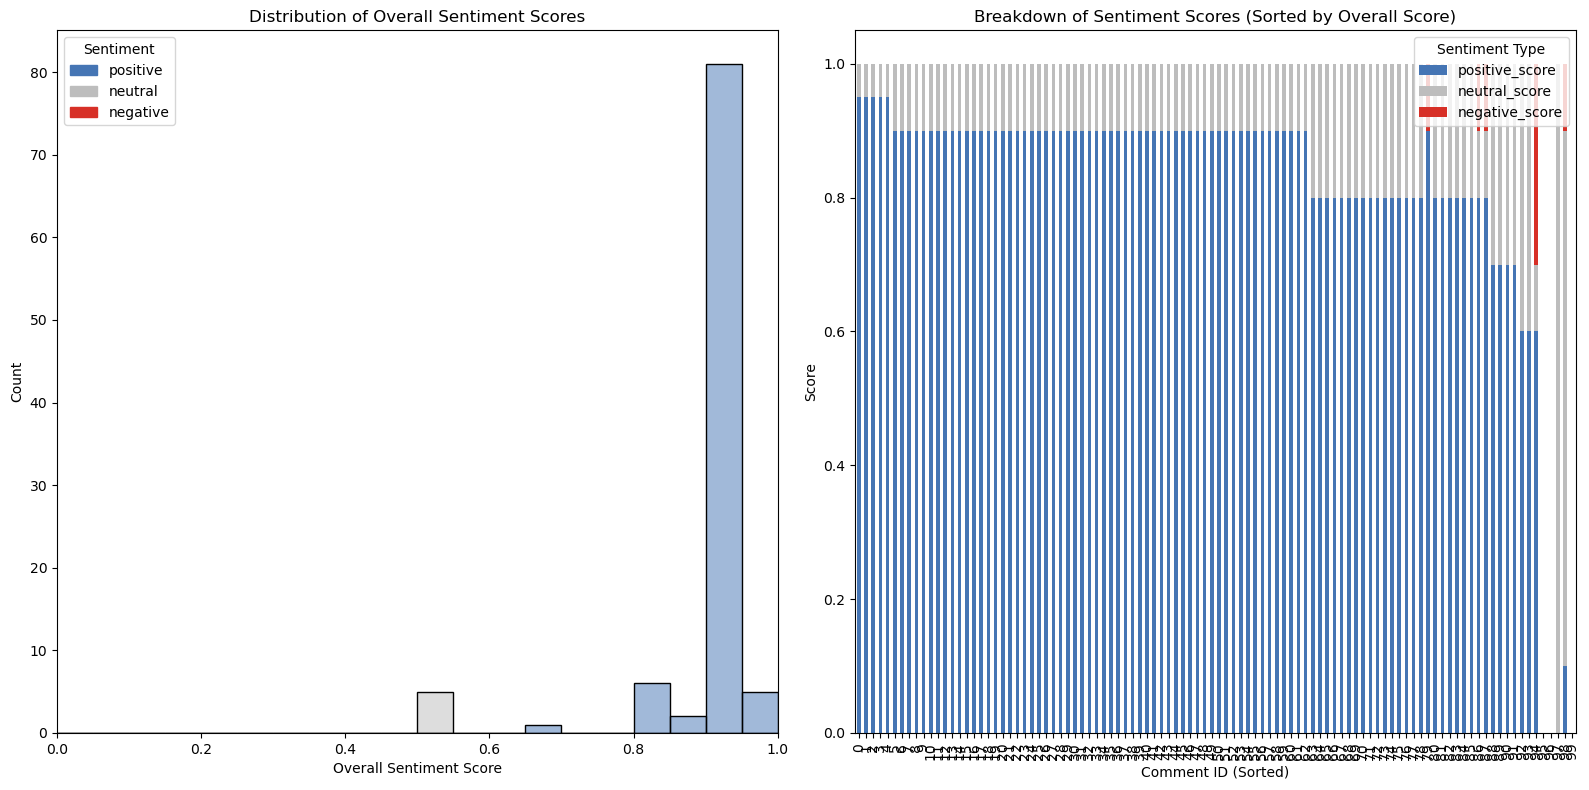

In [50]:
visualize_sentiment_results(sentiment_results=best_parts_sentiment_results)

Interesting...overwhelmingly positive (as we would expect, based on the question), but you can see that there are a few that are neutral. We could dive into those if doing an analyis. Now let's do the same visualization for the "What could be improved" comments.

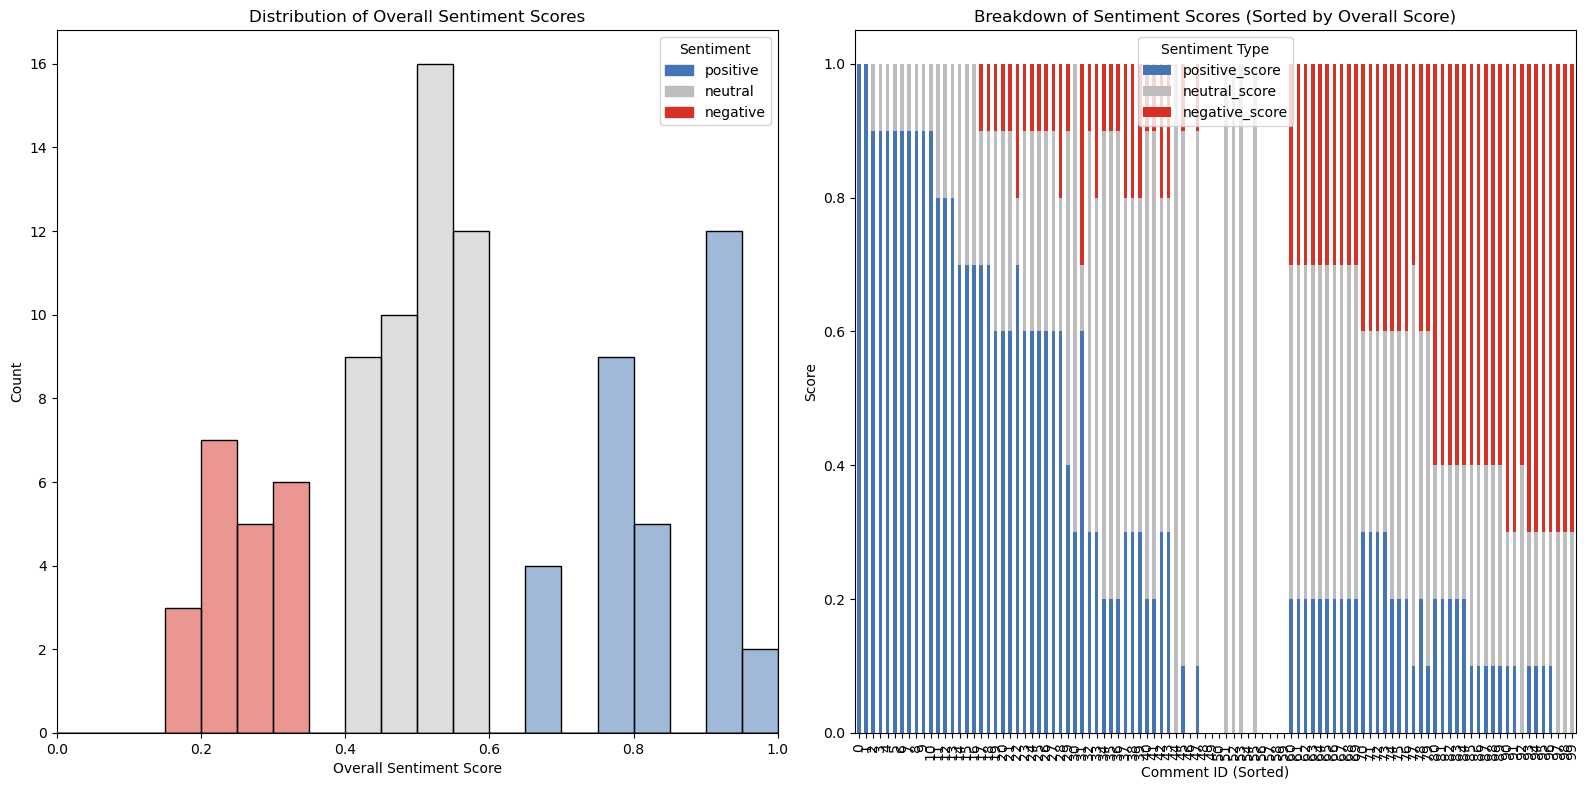

In [51]:
visualize_sentiment_results(sentiment_results=improve_course_sentiment_results)

That makes sense! You would expect asking for suggestions for improvement to elicit some comments that could be more negative, and you can see, based on the colors, how the sentiment has shifted relative to the best parts comments.

Just a note that for sure using an LLM is not the only way to do sentiment analysis, but some of the specialized models out there that I tried didn't match up against human intuition/ratings all that well, perhaps based on the fact that tweets (or similar training data) are fairly different than course reviews.

## 3. What did students say about some aspect of interest? (extraction)

In this case, let's say we want to know what suggestions for improvement students had about the lectures and videos. We can define that as our goal focus and pass that along.

In [52]:
goal_focus = "lectures and videos"
lec_vid_excerpts = await extract_excerpts(comments=improve_course_comments,
                                          question=improve_course_question,
                                          goal_focus=goal_focus)

# we'll just show a few for brevity but feel free to change the slice
for comment, excerpts in list(zip(improve_course_comments, lec_vid_excerpts))[:5]:
    print_wrap(f'Student comment: "{comment}"')
    pprint(excerpts.model_dump())
    print('\n')

processing 100 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 7.553528070449829
sleeping for 12.446471929550171 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 7.131534814834595
sleeping for 12.868465185165405 seconds
starting 50 to 75
completed 50 to 75
elapsed time: 8.24376392364502
sleeping for 11.75623607635498 seconds
starting 75 to 100
completed 75 to 100
elapsed time: 7.445266246795654
Student comment: "Consider reducing the duration of certain videos. A
few appeared to be slightly prolonged."
{'excerpts': ['Consider reducing the duration of certain videos. A few '
              'appeared to be slightly prolonged.']}


Student comment: "The pace of some lectures could be slowed down. At
times, it's challenging to follow the lecturer's speech or decipher
their handwriting."
{'excerpts': ["The pace of some lectures could be slowed down. At times, it's "
              "challenging to follow the lecturer's 

That seemed to work well. You can see from looking at the output of how it did extraction on the first 5 of the comments that it honed in on the parts about the lectures and vides. As an example, the comment

> "Extend the duration of the concept videos for the more
challenging topics, as they require a deeper dive to fully grasp the
intricacies involved. Additionally, consider introducing an additional
educator to the mix. The dynamic of having multiple voices in another
subject area is quite engaging, and it would be beneficial to replicate
that experience in this subject to prevent monotony from setting in with
just one instructor."

had excerpts:

> "Extend the duration of the concept videos for the more challenging topics, as they require a deeper dive to fully grasp the intricacies involved."
              
and

> "The dynamic of having multiple voices in another subject area is quite engaging, and it would be beneficial to replicate that experience in this subject to prevent monotony from setting in with just one instructor."

with the first having to do with videos and the second one having to do with lectures.

Also note that there were no excerpts in for comments that were not relevant to the goal focus.

## 4. How did they feel about that aspect (focused sentiment analysis)

Now we can analyze the sentiment of the excerpts for a more nuanced picture. Remember, these are in response to the "how can the course be improved?" question, so we would expect a bit more of a negative skew, given that that is the way the question is oriented.

In [53]:
# first get all the excerpts in a single flattened list
from itertools import chain
lec_vid_excerpts_flat = list(chain.from_iterable(result.excerpts for result in lec_vid_excerpts if result.excerpts))
lec_video_sentiment_results = await classify_sentiment(comments=lec_vid_excerpts_flat, 
                                                       question="How could the lectures and videos be improved?")

processing 25 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 13.87559723854065


...and check out the three most positive and three most negative comments, as well as visualize the sentiment results.

In [54]:
display_top_comments(comments=lec_vid_excerpts_flat, sentiment_results=lec_video_sentiment_results, n=3, sentiment='positive')
display_top_comments(comments=lec_vid_excerpts_flat, sentiment_results=lec_video_sentiment_results, n=3, sentiment='negative')



Top 3 Positive Comments:
Comment: Incorporating additional visual aids could enhance and solidify the
understanding of the material.
Sentiment: (Overall score: 0.75)
Distribution: +0.60, 0.30, -0.10
--------------------------------------------------------------------------------
Comment: Incorporating a live tutoring option during video playback could be
beneficial.
Sentiment: (Overall score: 0.75)
Distribution: +0.60, 0.30, -0.10
--------------------------------------------------------------------------------
Comment: Incorporate additional multimedia presentations regarding practical
patient scenarios
Sentiment: (Overall score: 0.75)
Distribution: +0.60, 0.30, -0.10
--------------------------------------------------------------------------------

Top 3 Negative Comments:
Comment: The section involving microscopic imagery, where indicators were used
to highlight specific cellular structures, progressed too quickly for
those with limited experience.
Sentiment: (Overall score: 0.20)
Di

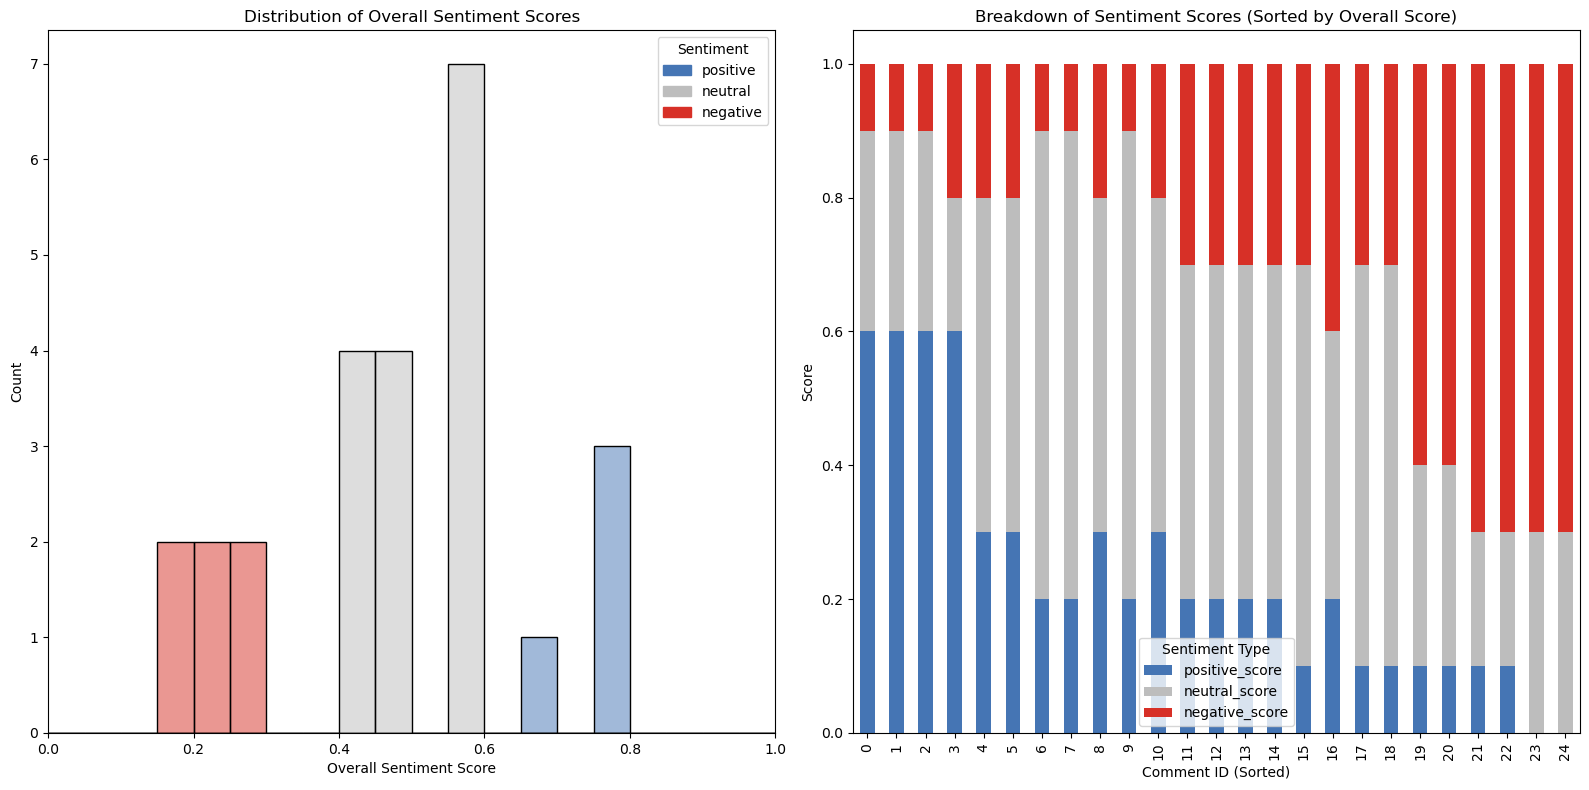

In [55]:
visualize_sentiment_results(sentiment_results=lec_video_sentiment_results)

Not bad...the overall sentiment distribution is pretty similar to the sentiment distribution of the "how can the coures be improved?" comments we looked at previously. The excerpts are sometimes brief and judging sentiment in a fine-grained way is not so easy. But you can imagine that if you had one thousand such excerpts, having some judgment of sentiment might help you prioritize.

## 5. How many comments were there about different aspects? (multilabel classification)

Here we get into quantification of what comments were about. It would be helpful to have that kind of quantification, particularly if we're trying to use the data to help with decisions about whether it's worth it to devote resources (including time and energy) to make changes to the course based on the feedback.

There are (at least) a couple of ways we can go about quantifying. One is to continue the bottom-up approach and use the themes derived from the comments themselves to classify the comments. The second way is what I would label top-down, which essentially means using a pre-defined set of tags or labels. These are based on major areas of interest that are applicable to many types of courses. Using a pre-defined set of tags also allows better comparison across cohorts as you act on feedback and make iterative changes to a course.

### Multi-label classification (bottom-up tags)

Let's use the theme derivation results to quantify how many comments were about each theme. The themes weren't intended as category labels, but we can effectively use them that way and classify the comments using multilabel classification.  

First we'll turn the themes derived from the 'best parts' comments into the format needed (a list of dictionaries). We could also load tags from a file, as we'll see when we do the top-down approach.

In [56]:
best_parts_tags = [{'topic': theme.theme_title, 'description': theme.description}
                  for theme in best_parts_themes.themes]

best_parts_tags

[{'topic': 'Visual Aids and Multimedia',
  'description': '• Effective use of visual presentations and animations\n• Clarification of complex concepts through illustrations\n• Engaging video content enhancing understanding'},
 {'topic': 'Practical Applications',
  'description': '• Connection of theoretical concepts to real-world scenarios\n• Inclusion of case studies and clinical applications\n• Hands-on interactive modules enhancing learning'},
 {'topic': 'Course Structure',
  'description': '• Clear organization and progression of topics\n• Breakdown of complex subjects into digestible parts\n• Effective presentation of material'},
 {'topic': 'Flexibility and Self-Pacing',
  'description': '• Ability to learn at own pace\n• Adaptability to individual schedules\n• Benefits for working professionals'},
 {'topic': 'Comprehensive Content',
  'description': '• Coverage of a wide range of topics\n• Inclusion of emerging treatments and research\n• Thorough examination of subject matter'},


Next we do the classification on the same comments that we derived the themes from.

In [57]:
mlc_best_parts_bottomup = await multilabel_classify(comments=best_parts_comments, 
                                                    tags_list=best_parts_tags)

processing 100 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 23.282060146331787
sleeping for 16.717939853668213 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 25.466351747512817
sleeping for 14.533648252487183 seconds
starting 50 to 75
Rate limit error: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your per-minute rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}
Sleeping for 30 seconds and trying again...
Rate limit error: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your per-minute rate limit (

Let's look at a few of the output classifications, along with the model's reasoning for each. Any categories that are selected have 1 as the value.

In [58]:
for comment, classification in list(zip(best_parts_comments, mlc_best_parts_bottomup))[:3]:
    pprint(comment)
    pprint(json.loads(classification.model_dump_json()))
    print('\n')

('I valued the practical clinical aspects related to immune-related disorders '
 'and their management.')
{'categories': {'Additional_Resources': 0,
                'Assessment_Quality': 0,
                'Clinical_and_Laboratory_Applications': 1,
                'Comprehensive_Content': 0,
                'Course_Structure': 0,
                'Engaging_Content': 0,
                'Flexibility_and_Self-Pacing': 0,
                'Foundational_Knowledge': 0,
                'Interactive_Elements': 0,
                'Patient_Interactions': 0,
                'Practical_Applications': 1,
                'Quality_of_Instruction': 0,
                'Specific_Topic_Areas': 1,
                'Visual_Aids_and_Multimedia': 0},
 'reasoning': 'The comment "I valued the practical clinical aspects related to '
              'immune-related disorders and their management" can be '
              'categorized into three main categories:\n'
              '\n'
              '1. Clinical and Labor

The above is not easy to look at efficiently. Let's turn the results into a dataframe...something you would typically do to download the results.

In [60]:
# make a dataframe with comments in one column and the pivoted tag categories as the other columns
results_df = pd.DataFrame({'comment': best_parts_comments})
values_df = pd.json_normalize([classification.categories.model_dump() for classification in mlc_best_parts_bottomup]).map(lambda x: x.value)
reasoning_df = pd.DataFrame({"reasoning": [classification.reasoning for classification in mlc_best_parts_bottomup]})

bp_results_df = pd.concat([results_df, reasoning_df, values_df], axis=1)

full_show(bp_results_df.head(3))

,comment,reasoning,Visual_Aids_and_Multimedia,Practical_Applications,Course_Structure,Flexibility_and_Self-Pacing,Comprehensive_Content,Interactive_Elements,Clinical_and_Laboratory_Applications,Quality_of_Instruction,Specific_Topic_Areas,Additional_Resources,Engaging_Content,Assessment_Quality,Patient_Interactions,Foundational_Knowledge
0,I valued the practical clinical aspects related to immune-related disorders and their management.,"The comment ""I valued the practical clinical aspects related to immune-related disorders and their management"" can be categorized into three main categories:\n\n1. Clinical and Laboratory Applications (1): The comment explicitly mentions ""practical clinical aspects,"" which directly aligns with this category's description of ""Inclusion of practical clinical aspects"" and ""Application of concepts to medical practice.""\n\n2. Practical Applications (1): The phrase ""practical clinical aspects"" also fits well with this category, as it indicates a connection between theoretical concepts and real-world scenarios, which is a key aspect of the ""Practical Applications"" category.\n\n3. Specific Topic Areas (1): The comment mentions ""immune-related disorders,"" which falls under the description of this category, specifically the ""Focus on immunology"" aspect.\n\nThe other categories do not apply to this comment as it does not mention visual aids, course structure, flexibility, comprehensive content, interactive elements, quality of instruction, additional resources, engaging content, assessment quality, patient interactions, or foundational knowledge. The comment is focused specifically on the practical clinical aspects related to a specific topic area (immunology), making these three categories the most relevant.",0,1,0,0,0,0,1,0,1,0,0,0,0,0
1,The flexibility to learn at a self-determined speed,"The comment ""The flexibility to learn at a self-determined speed"" directly relates to the ""Flexibility and Self-Pacing"" category. This category is described as including the ""Ability to learn at own pace"" and ""Adaptability to individual schedules,"" which perfectly aligns with the student's feedback. The comment emphasizes the ability to control the pace of learning, which is a key aspect of flexibility in online courses. No other categories are applicable as the comment is specifically focused on the self-pacing aspect of the course and does not mention any other aspects such as content, structure, or specific topics.",0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,"The comment ""The educational content was extremely enriching and stimulating! The section on oncology was the highlight."" can be categorized into two main categories:\n\n1. Engaging Content (1): The comment directly states that the content was ""extremely enriching and stimulating."" This aligns with the description of the ""Engaging Content"" category, which includes ""Captivating and inspiring material"" and ""Stimulating learning experience."" The use of words like ""extremely"" and ""stimulating"" strongly indicates that the content was engaging and thought-provoking.\n\n2. Specific Topic Areas (1): The comment specifically mentions oncology as a highlight of the course. This falls under the ""Specific Topic Areas"" category, which includes ""Coverage of cellular processes and genetic concepts"" and ""Exploration of emerging medical fields."" Oncology is a specific medical field that is often covered in advanced biology or medical courses.\n\nOther categories were not assigned (0) because:\n- There's no mention of visual aids, practical applications, course structure, flexibility, comprehensiveness, interactive elements, clinical applications, quality of instruction, additional resources, assessment quality, patient interactions, or foundational knowledge.\n- While the content was described as enriching, which might imply comprehensive co

Let's turn this into a plot to get an overall sense. (This requires you have matplotlib and seaborn installed. Instead of this, feel free to download the dataframe and plot it in your favorite program).

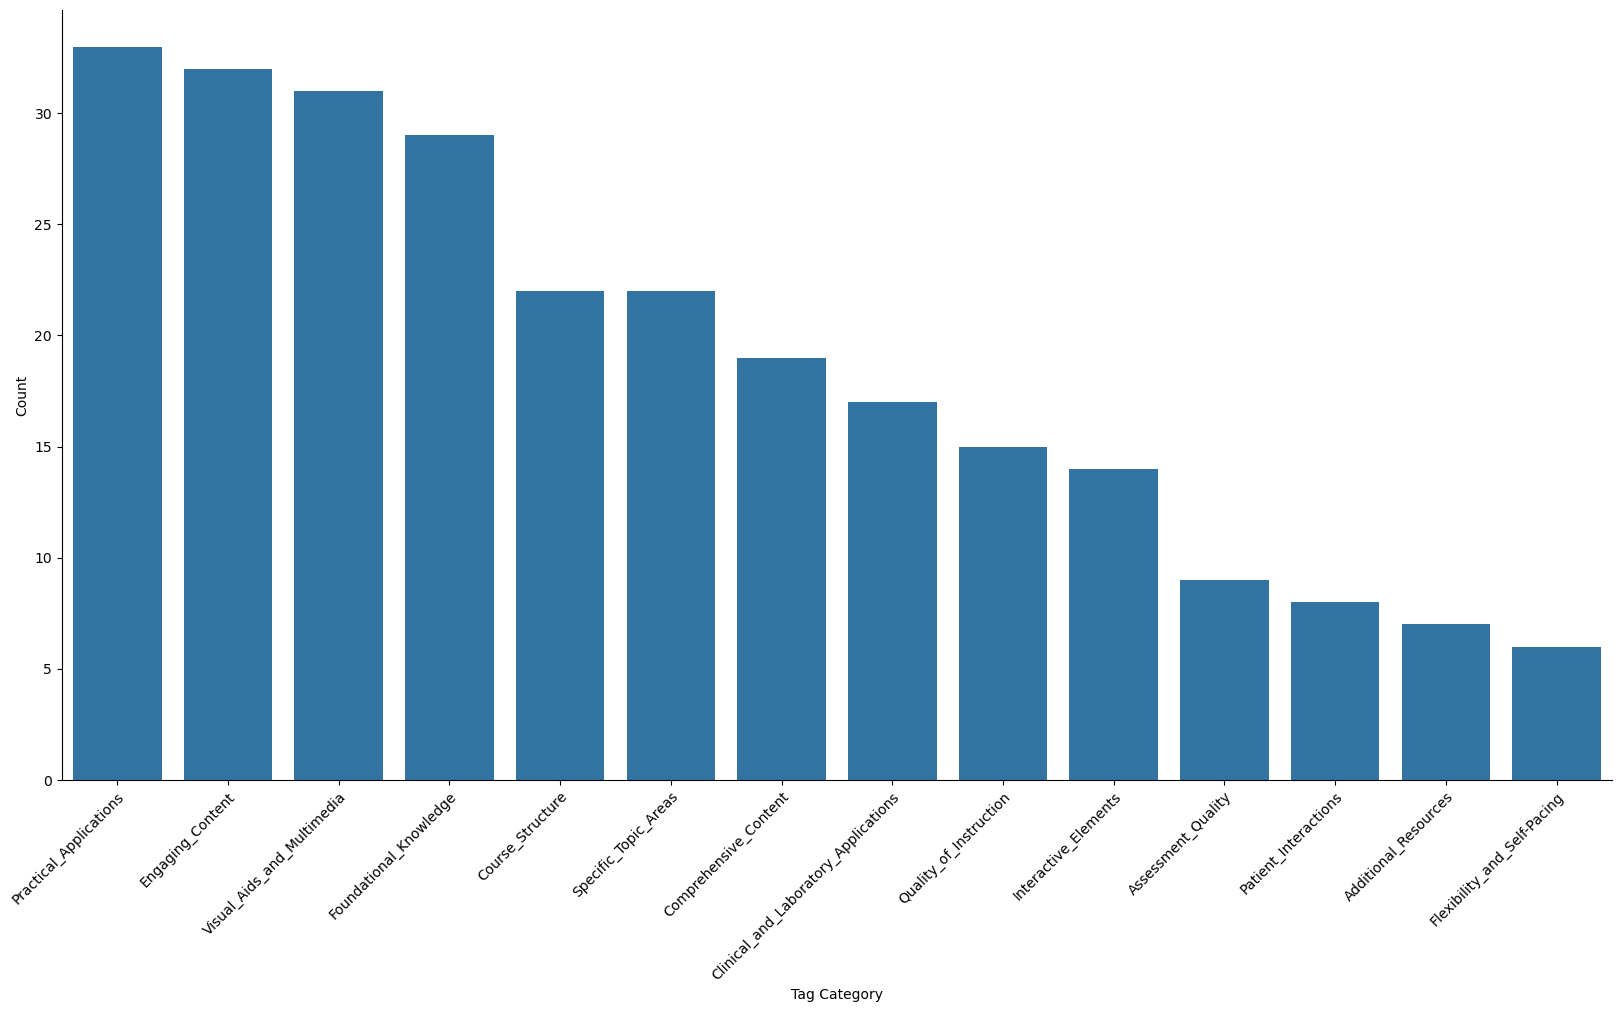

In [68]:
plt.figure(figsize=(20, 10))
data = bp_results_df.iloc[:, 2:].sum().sort_values(ascending=False).reset_index()
ax = sns.barplot(data=data, x='index', y=0)

ticks = ax.get_xticks()
labels = [item.get_text() for item in ax.get_xticklabels()]

ax.clear()
sns.barplot(data=data, x='index', y=0, ax=ax)

ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')

plt.ylabel("Count")
plt.xlabel("Tag Category")

sns.despine(top=True, right=True)

plt.show()

You can really get a sense of the top areas that people liked, even with these organically-derived, bottom up themes.

### Multi-label classification (top-down approach)

Here we come in with a set of labels that we've developed and stress-tested that should apply to many types of courses and classify comments based on those categories.

First let's take a look at the predefined tags.

In [69]:
default_tags_list

[{'topic': 'course logistics and fit',
  'description': 'course delivery (policy, support), cost, difficulty, time commitment, grading, credit, schedule, user fit, access, background (e.g. prereqs and appropriateness of course level).'},
 {'topic': 'curriculum',
  'description': 'course content, curriculum, specific topics, course structure.  This focuses on the content and the pedagogical structure of the content, including flow and organization.  This also includes applied material such as clinical cases and case studies. Includes references to pre-recorded discussions between experts or between a doctor and a patient. Includes specific suggestions for additional courses or content.'},
 {'topic': 'teaching modality',
  'description': 'video, visual, interactive, animation, step-by-step, deep dive, background builder (the format rather than the content/topic).'},
 {'topic': 'teaching',
  'description': 'instructors, quality of teaching and explanations'},
 {'topic': 'assessment', 'des

Next we do the classification and take a look at a few of the output classifications, along with the model's reasoning for each.

In [70]:
mlc_best_parts_topdown = await multilabel_classify(comments=best_parts_comments) 

for comment, classification in list(zip(best_parts_comments, mlc_best_parts_topdown))[:3]:
    pprint(comment)
    pprint(json.loads(classification.model_dump_json()))
    print('\n')

processing 100 inputs in batches of 25
sleeping for 20 seconds between batches
starting 0 to 25
completed 0 to 25
elapsed time: 13.507522106170654
sleeping for 6.492477893829346 seconds
starting 25 to 50
completed 25 to 50
elapsed time: 18.07317805290222
sleeping for 1.9268219470977783 seconds
starting 50 to 75
completed 50 to 75
elapsed time: 24.280622959136963
sleeping for 15.719377040863037 seconds
starting 75 to 100
completed 75 to 100
elapsed time: 23.395355939865112
('I valued the practical clinical aspects related to immune-related disorders '
 'and their management.')
{'categories': {'assessment': 0,
                'course_logistics_and_fit': 0,
                'curriculum': 1,
                'other': 0,
                'peer_and_teacher_interaction': 0,
                'resources': 0,
                'teaching': 0,
                'teaching_modality': 0},
 'reasoning': 'The comment "I valued the practical clinical aspects related to '
              'immune-related disorders 

Let's turn the results into a dataframe.

In [71]:
# make a dataframe with comments in one column and the pivoted tag categories as the other columns
td_results_df = pd.DataFrame({'comment': best_parts_comments})
td_values_df = pd.json_normalize([classification.categories.model_dump() for classification in mlc_best_parts_topdown]).map(lambda x: x.value)
td_reasoning_df = pd.DataFrame({"reasoning": [classification.reasoning for classification in mlc_best_parts_topdown]})

td_results_df = pd.concat([td_results_df, td_reasoning_df, td_values_df], axis=1)

full_show(td_results_df.head(3))

,comment,reasoning,course_logistics_and_fit,curriculum,teaching_modality,teaching,assessment,resources,peer_and_teacher_interaction,other
0,I valued the practical clinical aspects related to immune-related disorders and their management.,"The comment ""I valued the practical clinical aspects related to immune-related disorders and their management"" falls primarily under the curriculum category. Here's the reasoning:\n\n1. Curriculum (1): The comment directly refers to the course content, specifically mentioning ""practical clinical aspects related to immune-related disorders and their management."" This aligns with the curriculum category description, which includes ""course content, curriculum, specific topics"" and ""applied material such as clinical cases."" The student is expressing appreciation for the practical and applied nature of the course content related to a specific medical topic (immune-related disorders).\n\n2. Other categories (0): The comment does not mention or imply anything related to course logistics, teaching modality, specific teaching quality, assessments, resources, or peer/teacher interactions. It's a focused statement about the curriculum content.\n\nTherefore, the only applicable category for this comment is curriculum.",0,1,0,0,0,0,0,0
1,The flexibility to learn at a self-determined speed,"The comment ""The flexibility to learn at a self-determined speed"" primarily falls under the category of ""course logistics and fit"". This is because:\n\n1. Course logistics and fit: The comment directly addresses the flexibility in the course structure, which allows students to learn at their own pace. This relates to the course delivery and user fit aspects mentioned in the category description. The ability to determine one's own learning speed is an important aspect of course logistics, as it affects how students can manage their time and engage with the course material.\n\n2. Other categories: The comment does not specifically mention or imply any content related to curriculum, teaching modality, teaching quality, assessment, resources, or peer and teacher interaction. It also doesn't fall into the ""other"" category as it has a clear fit with ""course logistics and fit"".\n\nTherefore, the only applicable category for this comment is ""course logistics and fit"".",1,0,0,0,0,0,0,0
2,The educational content was extremely enriching and stimulating! The section on oncology was the highlight.,"The comment primarily focuses on the educational content and specifically mentions a section on oncology. This clearly falls under the ""curriculum"" category, which includes course content, specific topics, and course structure. The student describes the content as ""extremely enriching and stimulating,"" indicating a positive experience with the curriculum. No other categories are directly addressed in this comment. There's no mention of course logistics, teaching modality, instructors, assessments, resources, or peer/teacher interactions. While the comment is generally positive, it's not vague enough to warrant the ""other"" category, as it specifically relates to the curriculum.",0,1,0,0,0,0,0,0


Now let's plot this one. (Again, this requires you have matplotlib and seaborn installed. Instead of this, feel free to download the dataframe and plot it in your favorite program).

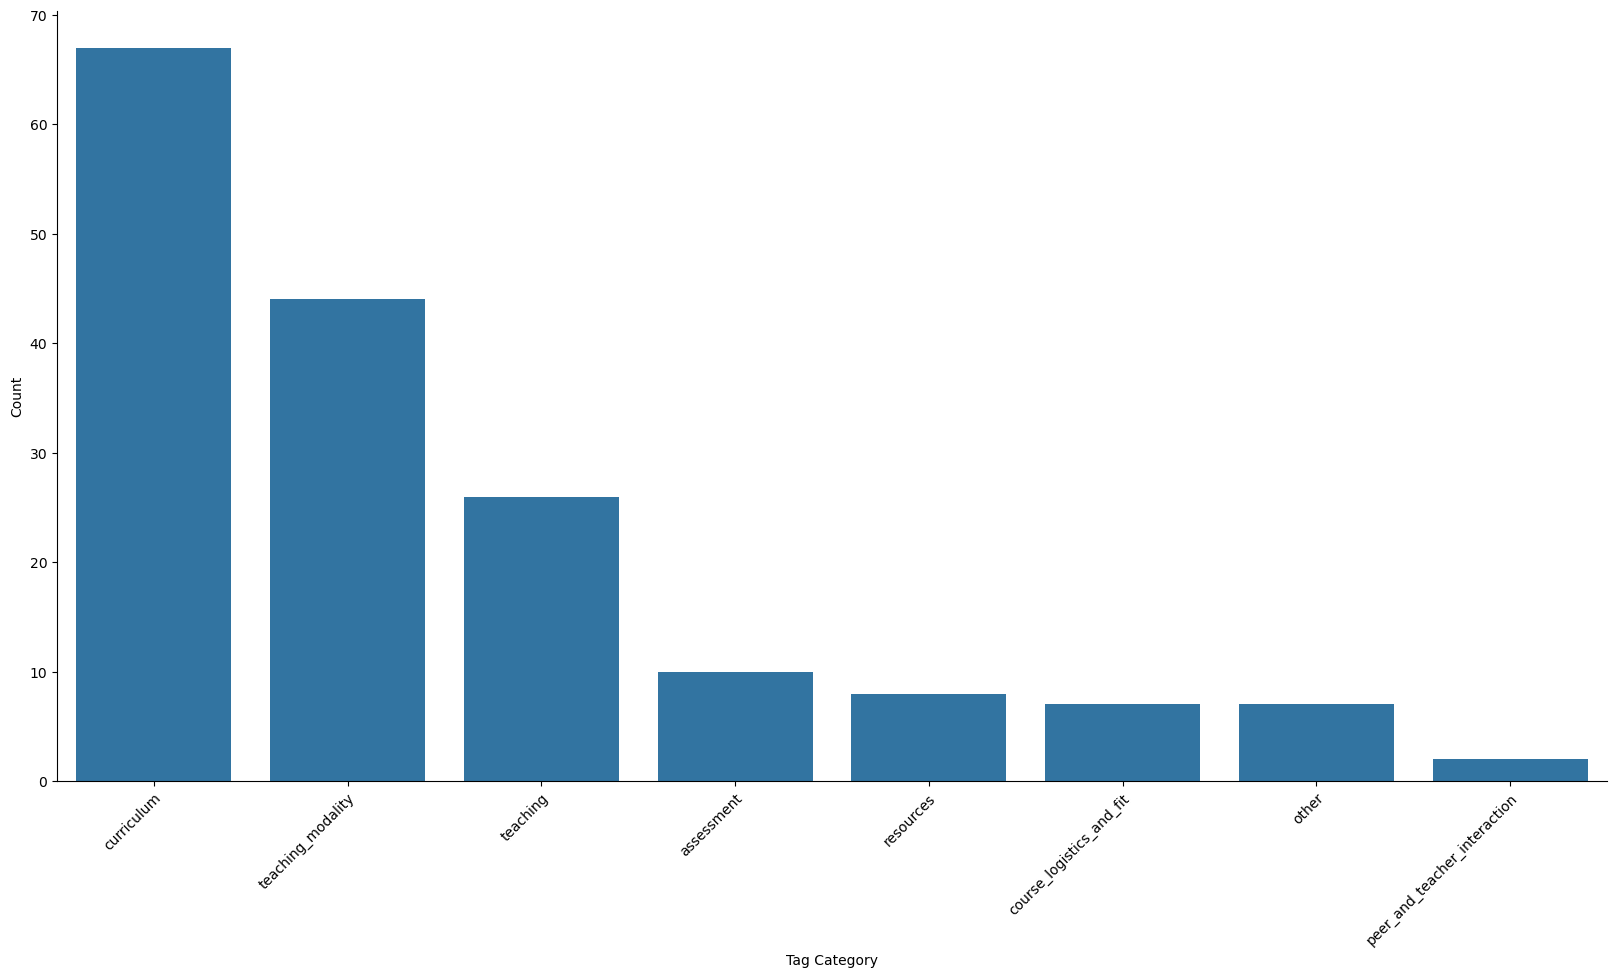

In [73]:
plt.figure(figsize=(20, 10))
data = td_results_df.iloc[:, 2:].sum().sort_values(ascending=False).reset_index()
ax = sns.barplot(data=data, x='index', y=0)
ticks = ax.get_xticks()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.clear()
sns.barplot(data=data, x='index', y=0, ax=ax)
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel("Count")
plt.xlabel("Tag Category")
sns.despine(top=True, right=True)
plt.show()

Just out of curiosity, let's see what was said in the course_logistics_and_fit category.

In [74]:
for comment in td_results_df.loc[lambda x: x['course_logistics_and_fit'] == 1, 'comment'].to_list():
    print_wrap(f'"{comment}"') # print helper defined under imports and setup
    print('\n')

"The flexibility to learn at a self-determined speed"


"Every session was enlightening. Initially, the assessments appeared
quite demanding, especially since my background is in a distinct field.
The questions in the assessments demanded not just familiarity with the
session content, but also a more profound comprehension. Despite the
initial difficulty, it was beneficial to delve into additional resources
and witness my comprehension evolve. The assessments were truly
insightful."


"The most advantageous aspects of the course included its digital format
and the adaptability regarding the timing for completing various
segments. This flexibility was particularly beneficial for me as a full-
time employee, as it enabled consistent participation in the course that
would have been challenging otherwise."


"I valued the advanced nature of the teaching (it wasn't overly
simplistic), and I was particularly fond of the autonomy in progressing
at a pace that suited my personal timetable."




It's interesting to be able to zero in on comments like these. It's one thing when you have a small number of comments, but with hundreds or even thousands of feedback comments, having the ability to drill down into results is incredibly helpful.